# Adversarial Attacks - Adversarial Patches Only

## edited by Nathan Bush for class project

originally created by Phillip Lippe and modified by Dr. Brinnae Bent for use in "Emerging Trends in Explainable AI" at Duke University.

Click on the button below to open in Google Colab. You will need access to a GPU to run this code.

<a href="https://colab.research.google.com/github/Nathan-Bush46/AIPI-Interpretable-ML/blob/main/assignments/adversarial_attacks_patches.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>




In [28]:
# note cleaned this up
## --- Standard libraries ---
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## --- Plotting ---
import matplotlib.pyplot as plt
%matplotlib inline

# Compatible import for modern IPython
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')  # For export-quality inline plots

from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

import seaborn as sns
sns.set()

## --- Progress bar ---
from tqdm.notebook import tqdm

## --- PyTorch ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## --- Torchvision ---
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

## --- PyTorch Lightning ---
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    # For environments like Colab
    !pip install --quiet "pytorch-lightning>=2.0"
    import pytorch_lightning as pl

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

## --- Paths ---
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/tutorial10"

## --- Seed & Determinism ---
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## --- Device selection ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
%matplotlib inline


Seed set to 42


Using device: cuda:0


In [29]:
# --- auto-fix for broken widget metadata (GitHub render issue) ---
import nbformat, os
from pathlib import Path

nb_path = Path(__file__) if "__file__" in globals() else Path("adversarial_attacks_patches.ipynb")
if nb_path.exists():
    try:
        nb = nbformat.read(nb_path, as_version=4)
        if "widgets" in nb.get("metadata", {}):
            nb["metadata"].pop("widgets")
            nbformat.write(nb, nb_path)
            print("🧹 Removed stale widget metadata to keep GitHub rendering clean.")
    except Exception as e:
        print("Widget cleanup skipped:", e)


We have again a few download statements. This includes both a dataset, and a few pretrained patches we will use later.

In [30]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

## Setup

For our experiments in this notebook, we will use common CNN architectures trained on the ImageNet dataset. Such models are luckily provided by PyTorch's torchvision package, and hence we just need to load the model of our preference. For the results on the website and default on Google Colab, we use a ResNet34. Feel free to experiment with other architectures as well, the code is mainly independent of the specific architecture we choose.

In [31]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

To perform adversarial attacks, we also need a dataset to work on. Given that the CNN model has been trained on ImageNet, it is only fair to perform the attacks on data from ImageNet. For this, we provide a small set of pre-processed images from the original ImageNet dataset (note that this dataset is shared under the same [license](http://image-net.org/download-faq) as the original ImageNet dataset). Specifically, we have 5 images for each of the 1000 labels of the dataset. We can load the data below, and create a corresponding data loader.

In [32]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

# this is where my code starts. 
## many of the functions are similar to what was already there just modifed to work for diffrent roations and patch sizes
### My patch focuses on missles

In [33]:
# === differentiable flexible patch training (torch-only, no PIL in loop) ===
# uses: pretrained_model, data_loader, device, label_names, get_label_index,
#       NORM_MEAN, NORM_STD, CHECKPOINT_PATH

import os, random, math
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt


# Chat gpt used for parmaters to set them up on 11/2
# ----------------- user knobs -----------------
TARGET_NAME = "missile"
PATCH_MIN = 8
PATCH_MAX = 64         # TinyImageNet is 64x64, so this is max
BASE_SIZE = PATCH_MAX  # learned parameter size
EPOCHS = 10             # smaller; 
LR = 0.1               # a bit higher to actually move
NUM_PLACEMENTS = 4     # per batch sample
TV_WEIGHT = 1e-4       
L2_WEIGHT = 1e-6
ROTATE = True          # turn off if you want to debug; rotation is differentiable now :)
ROT_RANGE_DEG = 30
SEED = 42
# ---------------------------------------------

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

MEAN_T = torch.tensor(NORM_MEAN, device=device).view(1,3,1,1)
STD_T  = torch.tensor(NORM_STD, device=device).view(1,3,1,1)

# find target idx
def find_label_index_by_name(name):
    try:
        return get_label_index(name)
    except AssertionError:
        for i, lname in enumerate(label_names):
            if lname.lower() == name.lower():
                return i
        for i, lname in enumerate(label_names):
            if name.lower() in lname.lower():
                return i
        raise ValueError(f"Target '{name}' not found.")
TARGET_IDX = find_label_index_by_name(TARGET_NAME)
print(f"Target class: {label_names[TARGET_IDX]} ({TARGET_IDX})")

pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

# learnable base patch
patch_param = nn.Parameter(torch.zeros(1, 3, BASE_SIZE, BASE_SIZE, device=device))
with torch.no_grad():
    patch_param.uniform_(-0.5, 0.5)  # start with something not-flat


# Chat gpt used for help functions and to modify original
# ---- helpers ----
def param_to_pixels01(p):
    # p: (1,3,H,W)
    return (torch.tanh(p) + 1) / 2   # (1,3,H,W) in [0,1]

def pixels01_to_norm(px):
    # px: (1,3,h,w)
    return (px - MEAN_T) / STD_T

def sample_size():
    return random.randint(PATCH_MIN, PATCH_MAX)

def sample_angle_rad():
    deg = random.uniform(-ROT_RANGE_DEG, ROT_RANGE_DEG)
    return math.radians(deg)

def resize_patch(px01, size):
    # px01: (1,3,H,W)
    if size == BASE_SIZE:
        return px01
    return F.interpolate(px01, size=(size, size), mode="bilinear", align_corners=False)

def rotate_patch(px01, angle_rad):
    # px01: (1,3,s,s)
    if not ROTATE or abs(angle_rad) < 1e-4:
        return px01
    B, C, H, W = px01.shape
    theta = torch.zeros(B, 2, 3, device=px01.device, dtype=px01.dtype)
    cos_a = math.cos(angle_rad)
    sin_a = math.sin(angle_rad)
    theta[:,0,0] = cos_a
    theta[:,0,1] = -sin_a
    theta[:,1,0] = sin_a
    theta[:,1,1] = cos_a
    grid = F.affine_grid(theta, size=px01.size(), align_corners=False)
    rot = F.grid_sample(px01, grid, mode="bilinear", padding_mode="zeros", align_corners=False)
    rot = torch.clamp(rot, 0.0, 1.0)
    return rot

def place_patch(imgs, patch_norm):
    # imgs: (B,3,H,W) normalized
    B, C, H, W = imgs.shape
    _, _, pH, pW = patch_norm.shape
    out = imgs.clone()
    for i in range(B):
        h_off = random.randint(0, H - pH)
        w_off = random.randint(0, W - pW)
        out[i, :, h_off:h_off+pH, w_off:w_off+pW] = patch_norm[0]
    return out

def total_variation(p):
    # p in param space -> tv in pixel space
    px = param_to_pixels01(p)
    tv_h = torch.mean(torch.abs(px[:, :, :, :-1] - px[:, :, :, 1:]))
    tv_w = torch.mean(torch.abs(px[:, :, :-1, :] - px[:, :, 1:, :]))
    return tv_h + tv_w


# ---- training ----
opt = torch.optim.Adam([patch_param], lr=LR)
ce = nn.CrossEntropyLoss()

steps = len(data_loader)
print("Start training (differentiable version)...")
for epoch in range(EPOCHS):
    # adjust LR manually: constant for 1–3, then half each epoch after until 5 then by 0.8 (this seemed to work ok)
    if epoch >= 3 and epoch <=5:
        for g in opt.param_groups:
            g['lr'] = g['lr'] * 0.5
        print(f"Learning rate reduced to {opt.param_groups[0]['lr']:.5f}")
    elif epoch>=6:
        for g in opt.param_groups:
            g['lr'] = g['lr'] * 0.8
        print(f"Learning rate reduced to {opt.param_groups[0]['lr']:.5f}")

    running = 0.0
    pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        B = imgs.size(0)

        logits_accum = 0
        for _ in range(NUM_PLACEMENTS):
            px01 = param_to_pixels01(patch_param)
            sz = sample_size()
            px01_s = resize_patch(px01, sz)
            ang = sample_angle_rad()
            px01_sr = rotate_patch(px01_s, ang)
            patch_norm = pixels01_to_norm(px01_sr)
            patched = place_patch(imgs, patch_norm)
            logits = pretrained_model(patched)
            logits_accum = logits_accum + logits

        logits_mean = logits_accum / float(NUM_PLACEMENTS)
        target = torch.full((B,), TARGET_IDX, device=device, dtype=torch.long)
        loss_cls = ce(logits_mean, target)
        loss_tv = total_variation(patch_param) * TV_WEIGHT
        loss_l2 = (torch.tanh(patch_param)**2).mean() * L2_WEIGHT
        loss = loss_cls + loss_tv + loss_l2

        opt.zero_grad()
        loss.backward()
        opt.step()

        running += loss.item()
        pbar.set_postfix(loss=running/(pbar.n+1e-9))

    # quick eval after epoch (coarse)
    pretrained_model.eval()
    fooled = 0
    total = 0
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(data_loader):
            if i > 10:
                break
            imgs = imgs.to(device)
            labels = labels.to(device)
            px01 = param_to_pixels01(patch_param)
            px01_s = resize_patch(px01, PATCH_MAX)
            px01_sr = rotate_patch(px01_s, 0.0)
            patch_norm = pixels01_to_norm(px01_sr)
            patched = place_patch(imgs, patch_norm)
            logits = pretrained_model(patched)
            preds = logits.argmax(1)
            mask = (labels != TARGET_IDX)
            fooled += (preds[mask] == TARGET_IDX).sum().item()
            total += mask.sum().item()
    if total > 0:
        print(f"Epoch {epoch+1}: fooling (quick) = {fooled/total*100:.2f}%")
    else:
        print(f"Epoch {epoch+1}: no non-targets in quick eval")

# save
torch.save({"patch_param": patch_param.detach().cpu()},
           os.path.join(CHECKPOINT_PATH, "patch_flexible_final.pth"))
print("saved to", os.path.join(CHECKPOINT_PATH, "patch_flexible_final.pth"))


Target class: missile (657)
Start training (differentiable version)...


Epoch 1/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: fooling (quick) = 0.28%


Epoch 2/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: fooling (quick) = 15.91%


Epoch 3/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: fooling (quick) = 17.33%
Learning rate reduced to 0.05000


Epoch 4/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: fooling (quick) = 20.45%
Learning rate reduced to 0.02500


Epoch 5/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5: fooling (quick) = 22.16%
Learning rate reduced to 0.01250


Epoch 6/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6: fooling (quick) = 22.44%
Learning rate reduced to 0.01000


Epoch 7/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7: fooling (quick) = 23.58%
Learning rate reduced to 0.00800


Epoch 8/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8: fooling (quick) = 21.59%
Learning rate reduced to 0.00640


Epoch 9/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9: fooling (quick) = 22.16%
Learning rate reduced to 0.00512


Epoch 10/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10: fooling (quick) = 25.00%
saved to ../saved_models/tutorial10/patch_flexible_final.pth


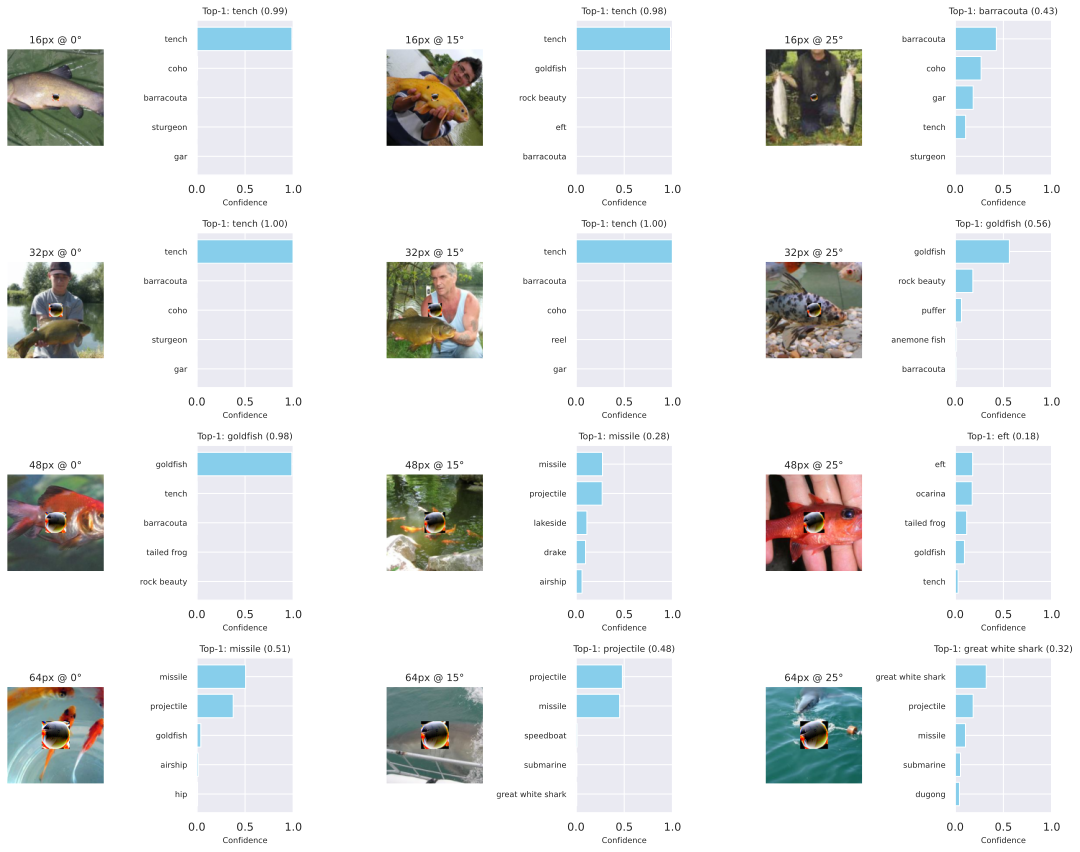

In [34]:
# --- Visual test: show patch effect at multiple sizes and rotations with bar charts ---

# mostly same as yours just used chat gpt to change for roation too
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def apply_patch_for_eval(img, patch_param, patch_size, angle_deg):
    """Resize, rotate, normalize, and place patch on a single image tensor (1,3,H,W)."""
    px01 = (torch.tanh(patch_param) + 1) / 2
    px01 = F.interpolate(px01, size=(patch_size, patch_size), mode="bilinear", align_corners=False)
    if abs(angle_deg) > 1e-3:
        theta = torch.tensor([[
            [math.cos(math.radians(angle_deg)), -math.sin(math.radians(angle_deg)), 0],
            [math.sin(math.radians(angle_deg)),  math.cos(math.radians(angle_deg)), 0]
        ]], dtype=torch.float, device=device)
        grid = F.affine_grid(theta, size=px01.size(), align_corners=False)
        px01 = F.grid_sample(px01, grid, mode="bilinear", padding_mode="zeros", align_corners=False)
    patch_norm = (px01 - MEAN_T) / STD_T

    _, _, H, W = img.shape
    _, _, pH, pW = patch_norm.shape
    h_off = (H - pH) // 2
    w_off = (W - pW) // 2
    patched = img.clone()
    patched[:, :, h_off:h_off+pH, w_off:w_off+pW] = patch_norm
    return patched


def show_patch_effects(patch_param, sizes=[16, 32, 48, 64], angles=[0, 15, -25]):
    pretrained_model.eval()
    imgs, labels = next(iter(data_loader))
    imgs = imgs[:len(sizes)*len(angles)].to(device)

    mean = torch.tensor(NORM_MEAN).view(1, 3, 1, 1)
    std = torch.tensor(NORM_STD).view(1, 3, 1, 1)

    n_rows = len(sizes)
    n_cols = len(angles)
    fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(n_cols * 5, n_rows * 3))
    if n_rows == 1:
        axes = axes[np.newaxis, :]  # ensure 2D array

    with torch.no_grad():
        for i, size in enumerate(sizes):
            for j, angle in enumerate(angles):
                idx = i * len(angles) + j
                img = imgs[idx:idx+1]
                patched = apply_patch_for_eval(img, patch_param, size, angle)
                logits = pretrained_model(patched)
                probs = F.softmax(logits, dim=1)
                top5p, top5i = torch.topk(probs, k=5, dim=1)

                img_disp = (patched.cpu() * std + mean).squeeze(0).permute(1, 2, 0).numpy().clip(0, 1)
                top_labels = [label_names[top5i[0, k]] for k in range(5)]
                top_scores = [top5p[0, k].item() for k in range(5)]

                # --- Left: patched image ---
                ax_img = axes[i, j * 2]
                ax_img.imshow(img_disp)
                ax_img.set_title(f"{size}px @ {angle}°", fontsize=10)
                ax_img.axis("off")

                # --- Right: top-5 bar chart ---
                ax_bar = axes[i, j * 2 + 1]
                ax_bar.barh(range(5), top_scores, color="skyblue")
                ax_bar.set_xlim(0, 1)
                ax_bar.set_yticks(range(5))
                ax_bar.set_yticklabels(top_labels, fontsize=8)
                ax_bar.invert_yaxis()  # highest on top
                ax_bar.set_xlabel("Confidence", fontsize=8)
                ax_bar.set_title(f"Top-1: {top_labels[0]} ({top_scores[0]:.2f})", fontsize=9)

    plt.tight_layout()
    plt.show()


# Run visualization
show_patch_effects(patch_param, sizes=[16, 32, 48, 64], angles=[0, 15, 25])

Evaluating patch sizes:   0%|          | 0/8 [00:00<?, ?it/s]

Size 8: top1=0.00%, top5=0.00%
Size 16: top1=0.00%, top5=0.00%
Size 24: top1=0.00%, top5=0.42%
Size 32: top1=0.00%, top5=7.71%
Size 40: top1=3.12%, top5=33.54%
Size 48: top1=6.67%, top5=72.92%
Size 56: top1=11.46%, top5=90.00%
Size 64: top1=11.88%, top5=94.79%


,Patch size,Top-1 fooling,Top-5 fooling
0,8,0.000000,0.000000
1,16,0.000000,0.000000
2,24,0.000000,0.004167
3,32,0.000000,0.077083
4,40,0.031250,0.335417
5,48,0.066667,0.729167
6,56,0.114583,0.900000
7,64,0.118750,0.947917


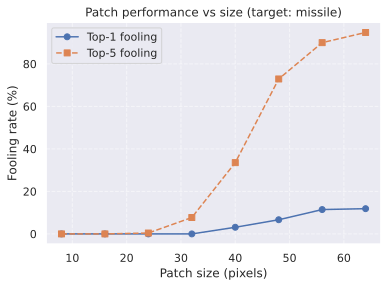

In [35]:
# --- Evaluate patch performance across patch sizes (8–64) ---
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random, math

@torch.no_grad()
def evaluate_patch_at_size(patch_param, patch_size, n_batches=20, n_places=4, angle_range=(-25,25)):
    pretrained_model.eval()
    total_non_target = 0
    fooled_top1 = 0
    fooled_top5 = 0

    for b_idx, (imgs, labels) in enumerate(data_loader):
        if b_idx >= n_batches:
            break
        imgs = imgs.to(device)
        labels = labels.to(device)
        B = imgs.size(0)

        prob_sum = torch.zeros(B, 1000, device=device)
        for _ in range(n_places):
            # build normalized patch with random rotation
            px01 = (torch.tanh(patch_param) + 1) / 2
            px01 = F.interpolate(px01, size=(patch_size, patch_size), mode="bilinear", align_corners=False)
            angle = random.uniform(*angle_range)
            theta = torch.tensor([[
                [math.cos(math.radians(angle)), -math.sin(math.radians(angle)), 0],
                [math.sin(math.radians(angle)),  math.cos(math.radians(angle)), 0]
            ]], dtype=torch.float, device=device)
            grid = F.affine_grid(theta, size=px01.size(), align_corners=False)
            px01 = F.grid_sample(px01, grid, mode="bilinear", padding_mode="zeros", align_corners=False)
            patch_norm = (px01 - MEAN_T) / STD_T

            _, _, H, W = imgs.shape
            _, _, pH, pW = patch_norm.shape
            h_off = random.randint(0, H - pH)
            w_off = random.randint(0, W - pW)
            patched = imgs.clone()
            patched[:, :, h_off:h_off+pH, w_off:w_off+pW] = patch_norm

            logits = pretrained_model(patched)
            prob_sum += F.softmax(logits, dim=1)

        prob_mean = prob_sum / float(n_places)
        non_target_mask = (labels != TARGET_IDX)
        num_non_target = non_target_mask.sum().item()
        if num_non_target == 0:
            continue
        total_non_target += num_non_target
        sorted_idx = torch.argsort(prob_mean, dim=1, descending=True)
        sel = sorted_idx[non_target_mask]
        fooled_top1 += (sel[:, 0] == TARGET_IDX).sum().item()
        fooled_top5 += (sel[:, :5] == TARGET_IDX).any(dim=1).sum().item()

    if total_non_target == 0:
        return 0.0, 0.0
    return fooled_top1 / total_non_target, fooled_top5 / total_non_target

# used gpt for graph
# --- Run for a range of patch sizes ---
sizes_to_test = [8, 16, 24, 32, 40, 48, 56, 64]
results = []
for sz in tqdm(sizes_to_test, desc="Evaluating patch sizes"):
    t1, t5 = evaluate_patch_at_size(patch_param, sz, n_batches=15)
    results.append({"Patch size": sz, "Top-1 fooling": t1, "Top-5 fooling": t5})
    print(f"Size {sz}: top1={t1*100:.2f}%, top5={t5*100:.2f}%")

df_results = pd.DataFrame(results)
display(df_results)

# --- Plot performance curve ---
plt.figure(figsize=(6,4))
plt.plot(df_results["Patch size"], df_results["Top-1 fooling"]*100, 'o-', label="Top-1 fooling")
plt.plot(df_results["Patch size"], df_results["Top-5 fooling"]*100, 's--', label="Top-5 fooling")
plt.xlabel("Patch size (pixels)")
plt.ylabel("Fooling rate (%)")
plt.title(f"Patch performance vs size (target: {label_names[TARGET_IDX]})")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# yeah not great but still intersting.
It looks like adding rotation and targeting “missile” made it much harder for the model to learn a single, general patch. The results show almost no fooling at smaller sizes and only modest success even at full scale.

Loaded patch tensor:
torch.Size([1, 3, 64, 64]) -4.551510334014893 4.575687408447266


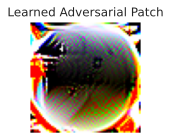

In [36]:
# --- load and print saved patch ---
ckpt = torch.load(os.path.join(CHECKPOINT_PATH, "patch_flexible_final.pth"), map_location=device)
patch_loaded = ckpt["patch_param"].to(device)

print("Loaded patch tensor:")
print(patch_loaded.shape, patch_loaded.min().item(), patch_loaded.max().item())

# convert param -> pixels for viewing
with torch.no_grad():
    px01 = (torch.tanh(patch_loaded) + 1) / 2  # [0,1] range

plt.figure(figsize=(2, 2))
plt.imshow(px01[0].permute(1, 2, 0).cpu().numpy())
plt.title("Learned Adversarial Patch")
plt.axis("off")
plt.show()


In [ ]:
from PIL import Image
import torch
import numpy as np
import os

# --- load and save learned patch as high-res PNG ---
ckpt_path = os.path.join(CHECKPOINT_PATH, "patch_flexible_final.pth")
ckpt = torch.load(ckpt_path, map_location=device)
patch_loaded = ckpt["patch_param"].to(device)

print("Loaded patch tensor:", patch_loaded.shape, patch_loaded.min().item(), patch_loaded.max().item())

# convert from parameter space -> pixel space [0,1]
with torch.no_grad():
    px01 = (torch.tanh(patch_loaded) + 1) / 2  # (1,3,H,W)
    img_np = (px01[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

# make PIL image
img = Image.fromarray(img_np)

# upscale 8× for printing clarity (adjust as you like)
scale_factor = 8
new_size = (img.width * scale_factor, img.height * scale_factor)
img_up = img.resize(new_size, Image.Resampling.BICUBIC)

# save both normal and upscaled versions losslessly
save_path_base = os.path.join(CHECKPOINT_PATH, "patch_flexible_final")
img.save(save_path_base + ".png", format="PNG", compress_level=0)
img_up.save(save_path_base + "_hires.png", format="PNG", compress_level=0)

print(f"Saved PNGs to:\n  {save_path_base}.png\n  {save_path_base}_hires.png ({new_size[0]}×{new_size[1]})")


Loaded patch tensor: torch.Size([1, 3, 64, 64]) -4.581021308898926 4.538125991821289
Saved PNGs to:
  ../saved_models/tutorial10/patch_flexible_final.png
  ../saved_models/tutorial10/patch_flexible_final_hires.png (512×512)
